# Biomassters PyTorch Training & Prediction Workflow

This is a basic workflow using Pytorch to predict pixel-level Above Ground Biomass using Sentinel 1 (SAR) and Sentinel 2 (Optical & IR) data for the [Biomassters](https://www.drivendata.org/competitions/99/biomass-estimation/) data competition.

**Motivations**
1. Illustrate data exploration and model training workflows with a time-boxed effort.
2. Demonstrate a basic PyTorch workflow since Python is less commonly used by the forest data community where R dominates. I avoided frameworks like [PyTorch Lightning](https://www.pytorchlightning.ai/) which are extremely powerful but less explicit about the step-by-step operations.
3. Demonstrate the value of ground cover indexes (such as [NDVI](https://eos.com/make-an-analysis/ndvi/), [NDSI](https://eos.com/make-an-analysis/ndsi/)) which may be unfamiliar to ML modelers from other domains 
4. Keep pre-processing minimal for the purpose of speed and interpretability. 
5. Share the work so that others can build on it. 

This simple workflow produced a score of RMSE=37.1 with ranking of 15th on the Biomassters competition as of time of writing (01DEC22). There are many areas for improvement that are beyond the scope of this quick exercise. 

**Further Enhancements to Try**
1. Training Inputs: refine tile selection, use multiple months per chip
2. Segmentation: leverage CLP band, explicitly segment high/low biomass areas 
3. Model: try different architectures & encoders 
4. Transformations: improve feature generation, better handling of outliers 

**Environment Notes**
* This was developed with a Macbook M1, so the gpu device is `mps` rather than the more common `cuda`
* Since PyTorch support for the M1 chip is fairly new, some of the code is a little hacky to work around unsupported features 
* The code should work on other platforms with few if any changes, but it hasn't been tested

### Imports

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import os
import rasterio
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, random_split
from torchgeo.transforms import indices
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning) # biomassters rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

#### Local Imports from transforms.py and dataloading.py

In [5]:
import transforms as tf
import data_loader as dl

### Setup GPU

In [6]:
# MPS Docs
# https://pytorch.org/docs/master/notes/mps.html

if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loader_device = torch.device('cpu')  # found that using cpu for data loading was faster than gpu (for my device)
print(f'training device: {device}')
print(f'loader_device: {loader_device}')

training device: cuda
loader_device: cpu


### Set directories for local environment

In [7]:
dir_tiles = '/workspace/BioMassters/data/train_features'
dir_target = '/workspace/BioMassters/data/train_agbm'
dir_saved_models = './trained_models'

In [8]:
# Map of tensor channels *after* transforms, not accounting for bands dropped by the DropBands transform
# Useful for choosing which bands to keep 
band_map = {  
    # S2 bands
    0: 'S2-B2: Blue-10m',
    1: 'S2-B3: Green-10m',
    2: 'S2-B4: Red-10m',
    3: 'S2-B5: VegRed-704nm-20m',
    4: 'S2-B6: VegRed-740nm-20m',
    5: 'S2-B7: VegRed-780nm-20m',
    6: 'S2-B8: NIR-833nm-10m',
    7: 'S2-B8A: NarrowNIR-864nm-20m',
    8: 'S2-B11: SWIR-1610nm-20m',
    9: 'S2-B12: SWIR-2200nm-20m',
    10: 'S2-CLP: CloudProb-160m',
    # S1 bands
    11: 'S1-VV-Asc: Cband-10m',
    12: 'S1-VH-Asc: Cband-10m',
    13: 'S1-VV-Desc: Cband-10m',
    14: 'S1-VH-Desc: Cband-10m',
    # Bands derived by transforms 
    15: 'S2-NDVI: (NIR-Red)/(NIR+Red) 10m',
    16: 'S1-NDVVVH-Asc: Norm Diff VV & VH, 10m',
    17: 'S2-NDBI: Difference Built-up Index, 20m',
    18: 'S2-NDRE: Red Edge Vegetation Index, 20m',
    19: 'S2-NDSI: Snow Index, 20m',
    20: 'S2-NDWI: Water Index, 10m',
    21: 'S2-SWI: Sandardized Water-Level Index, 20m',
    22: 'S1-VV/VH-Asc: Cband-10m',
    23: 'S2-VV/VH-Desc: Cband-10m'
}
month_map = {
    0: 'Sep', 1: 'Oct', 2: 'Nov', 3: 'Dec',
    4: 'Jan', 5: 'Feb', 6: 'Mar', 7: 'Apr',
    8: 'May', 9: 'Jun', 10: 'Jul', 11: 'Aug'
}

### Transforms
See https://torchgeo.readthedocs.io/en/latest/tutorials/indices.html and https://torchgeo.readthedocs.io/en/latest/api/transforms.html

In [9]:
bands_to_keep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21] # via offline feature selection  

transforms = nn.Sequential(
    tf.ClampAGBM(vmin=0., vmax=500.),                # exclude AGBM outliers, 500 is good upper limit per AGBM histograms 
    indices.AppendNDVI(index_nir=6, index_red=2),    # NDVI, index 15
    indices.AppendNormalizedDifferenceIndex(index_a=11, index_b=12), # (VV-VH)/(VV+VH), index 16
    indices.AppendNDBI(index_swir=8, index_nir=6),   # Difference Built-up Index for development detection, index 17
    indices.AppendNDRE(index_nir=6, index_vre1=3),   # Red Edge Vegetation Index for canopy detection, index 18
    indices.AppendNDSI(index_green=1, index_swir=8), # Snow Index, index 19
    indices.AppendNDWI(index_green=1, index_nir=6),  # Difference Water Index for water detection, index 20 
    indices.AppendSWI(index_vre1=3, index_swir2=8),  # Standardized Water-Level Index for water detection, index 21
    tf.AppendRatioAB(index_a=11, index_b=12),        # VV/VH Ascending, index 22
    tf.AppendRatioAB(index_a=13, index_b=14),        # VV/VH Descending, index 23
    tf.DropBands(loader_device, bands_to_keep)       # DROPS ALL BUT SPECIFIED bands_to_keep
)

### SentinelDataset - set `max_chips` 

In [10]:
# this file specifies which month of data to use for training for each chipid 
# See the preprocesing notebook for an example of producing this  
tile_file = 'tcmoran/TILE_LIST_BEST_MONTHS.csv'

In [11]:
max_chips = 200 # number of chips to use from training set, None = Use All  

# A custom dataloader for Sentinel data 
dataset = dl.SentinelDataset(tile_file=tile_file, 
                             dir_tiles=dir_tiles, 
                             dir_target=dir_target,
                             max_chips=max_chips,
                             transform=transforms,
                             device=loader_device
                            )

### Split Train/Valid ---Note: manual seed set for reproducibility---

In [12]:
torch.manual_seed(0)

train_frac = 0.8
train_dataset, val_dataset = random_split(dataset, [180, 20])
print(f'N training samples: {len(train_dataset)}')

N training samples: 180


### Dataloaders - set `batch_size` and `num_workers`

In [13]:
batch_size = 100  # Note: training speed is sensitive to memory usage
                 # set this as high as you can without significantly slowing down training time 
num_workers = 8
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True
                             )
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=num_workers,
                            pin_memory=True
                           )

### Initialize Model

In [49]:
in_channels = train_dataset[0]['image'].shape[0]
print(f'# input channels: {in_channels}')

model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None, # 'imagenet' weights don't seem to help so start clean 
    in_channels=in_channels,                 
    classes=1,                     
).to(device)

# input channels: 20


### ... Or load a saved model

In [15]:
# model.load_state_dict(torch.load(save_path))
# model.train()

### Define Loss Function & Optimizer 

In [12]:
loss_module = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

### Train & Validation Loops

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_metrics = []
    
    print('Training')
    for ix, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch['image'].to(device)
        y = batch['label'].to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_metrics.append(np.round(np.sqrt(loss.item()), 5))
            
    return train_metrics

In [14]:
def valid_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    valid_loss = 0
    valid_metrics = {}

    print('Validation')
    with torch.no_grad():
        for batch in tqdm(dataloader, total=num_batches):
            X = batch['image'].to(device)
            y = batch['label'].to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            
    valid_loss /= num_batches
    valid_rmse = np.round(np.sqrt(valid_loss), 5)
    print(f"Validation Error: \n RMSE: {valid_rmse:>8f} \n")
    return valid_rmse

# Run Training & Save Model
This checks the validation score at each epoch and saves the model if validation has improved 

In [15]:
def run_training(model, loss_module, optimizer, train_dataloader, val_dataloader, save_path, n_epochs=10):
    min_valid_metric = np.inf
    train_metrics = []
    valid_metrics = []

    for ix in range(n_epochs):
        print(f"\n-------------------------------\nEpoch {ix+1}")
        train_metrics_epoch = train_loop(train_dataloader, model, loss_module, optimizer)
        train_metrics.extend(train_metrics_epoch)
        
        valid_metrics_epoch = valid_loop(val_dataloader, model, loss_module)
        valid_metrics.append((len(train_metrics), valid_metrics_epoch))

        # check validation score, if improved then save model
        if min_valid_metric > valid_metrics_epoch:
            print(f'Validation RMSE Decreased({min_valid_metric:.6f}--->{valid_metrics_epoch:.6f}) \t Saving The Model')
            min_valid_metric = valid_metrics_epoch

            # Saving State Dict
            torch.save(model.state_dict(), save_path)
    print("Done!")
    train_metrics_zipped = list(zip(np.arange(0, len(train_metrics)), train_metrics))
    
    return {'training': train_metrics_zipped, 'validation': valid_metrics}

### Specify a model name for this run (otherwise previous models will be overwritten) 

In [16]:
save_file = 'UNET_resnet50_20band_batch32_AGBMLinear_AllTrain_5epoch_01DEC.pt'
save_path = os.path.join(dir_saved_models, save_file)

### Kickoff Training

In [ ]:
n_epochs = 20
metrics = run_training(model=model,
                       loss_module=loss_module,
                       optimizer=optimizer,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       save_path=save_file,
                       n_epochs=n_epochs)


-------------------------------
Epoch 1
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 80.036580 

Validation RMSE Decreased(inf--->80.036580) 	 Saving The Model

-------------------------------
Epoch 2
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 66.507220 

Validation RMSE Decreased(80.036580--->66.507220) 	 Saving The Model

-------------------------------
Epoch 3
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 56.323750 

Validation RMSE Decreased(66.507220--->56.323750) 	 Saving The Model

-------------------------------
Epoch 4
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 53.294600 

Validation RMSE Decreased(56.323750--->53.294600) 	 Saving The Model

-------------------------------
Epoch 5
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 51.719360 

Validation RMSE Decreased(53.294600--->51.719360) 	 Saving The Model

-------------------------------
Epoch 6
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 53.845360 


-------------------------------
Epoch 7
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 51.738460 


-------------------------------
Epoch 8
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 50.963560 

Validation RMSE Decreased(51.719360--->50.963560) 	 Saving The Model

-------------------------------
Epoch 9
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 50.960390 

Validation RMSE Decreased(50.963560--->50.960390) 	 Saving The Model

-------------------------------
Epoch 10
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 50.148710 

Validation RMSE Decreased(50.960390--->50.148710) 	 Saving The Model

-------------------------------
Epoch 11
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 50.703540 


-------------------------------
Epoch 12
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 49.613430 

Validation RMSE Decreased(50.148710--->49.613430) 	 Saving The Model

-------------------------------
Epoch 13
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 49.851030 


-------------------------------
Epoch 14
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 47.755670 

Validation RMSE Decreased(49.613430--->47.755670) 	 Saving The Model

-------------------------------
Epoch 15
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 47.841340 


-------------------------------
Epoch 16
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

Validation Error: 
 RMSE: 47.082760 

Validation RMSE Decreased(47.755670--->47.082760) 	 Saving The Model

-------------------------------
Epoch 17
Training


  0%|          | 0/6 [00:00<?, ?it/s]

Validation


  0%|          | 0/1 [00:00<?, ?it/s]

### Plot RMSE for Training & Validation 

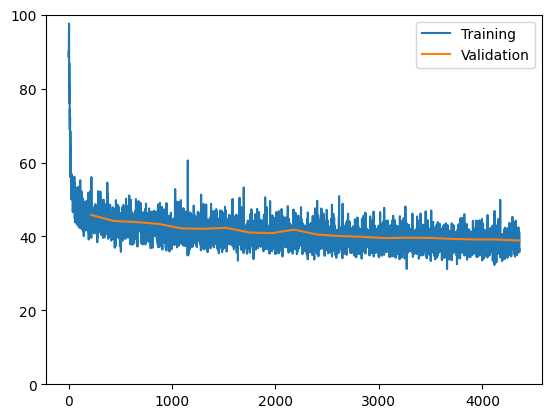

In [78]:
df_train_metrics = pd.DataFrame(metrics['training'], columns=['step', 'score'])
df_valid_metrics = pd.DataFrame(metrics['validation'], columns=['step', 'score'])
plt.plot(df_train_metrics['step'], df_train_metrics['score'], label='Training')
plt.plot(df_valid_metrics['step'], df_valid_metrics['score'], label='Validation')
plt.ylim([0, 100])
plt.legend()
plt.show()

#### Optionally load previously saved model

In [24]:
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(save_path))
# model.eval()

## Visualize Sample Predictions 

### True AGBM

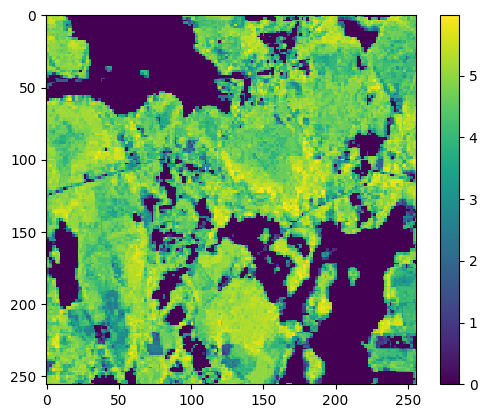

In [50]:
tile_idx = 1000  # arbitrary tile 

sample = dataset[tile_idx]
agbm = sample['label'].squeeze().detach().cpu().numpy()
agbm_log1p = np.log1p(agbm)  # visual comparison is easier with log transform; log1p handles small and 0 values
vmin = agbm_log1p.min()
vmax = agbm_log1p.max()

plt.imshow(agbm_log1p, vmin=vmin, vmax=vmax, interpolation='none')
plt.colorbar()
plt.show()

### Predicted AGBM

In [62]:
def predict_agbm(inputs, model):
    pred = model.predict(inputs.unsqueeze(0))
    return pred.detach().squeeze().cpu().numpy()

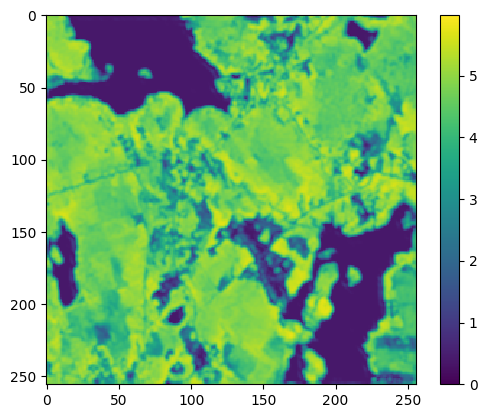

In [64]:
# Show predictions
model.to(device)

tile = sample['image'].to(device)
pred = predict_agbm(tile, model)

plt.imshow(np.log1p(pred), vmin=vmin, vmax=vmax, interpolation='none')
plt.colorbar()
plt.show()

# Process Predictions on Test Holdout

In [53]:
# List of best tiles (per chip) for test data 
tile_file_test = './TILE_LIST_BEST_MONTHS_TEST.csv'
# Test data dir
dir_test = '~/DATA/biomassters/tiles/test_features'
# Path to save predictions 
dir_save_preds = '~/DATA/biomassters/tiles/test_predictions'

### Define Test Dataset 

In [54]:
max_chips = None # number of chips to use, None = Use All  

dataset_test = dl.SentinelDataset(tile_file=tile_file_test, # specifies best months of test data 
                                  dir_tiles=dir_test,       # test data dir
                                  dir_target=None,          # No AGBM targets for test data 
                                  max_chips=max_chips,      
                                  transform=transforms,     # same transforms as training
                                  device=loader_device)

### Sanity Check: Example Prediction on Test Data

In [65]:
tile_idx = 99 # arbitrary tile 

chipid = dataset_test.df_tile_list.iloc[tile_idx]['chipid']
inputs = dataset_test[tile_idx]['image'].to(device)
agbm = predict_agbm(inputs, model)

plt.imshow(agbm)
plt.colorbar()
plt.show()

## Loop through and save all AGBM predictions

In [67]:
def save_agbm(agbm_pred, chipid):
    im = Image.fromarray(agbm_pred)
    save_path = os.path.join(dir_save_preds, f'{chipid}_agbm.tif')
    im.save(save_path, format='TIFF', save_all=True)

In [70]:
model.to(device)

for ix, tile in tqdm(enumerate(dataset_test), total=len(dataset_test)):
    chipid = dataset_test.df_tile_list.iloc[ix]['chipid']
    inputs = tile['image'].to(device)
    agbm = predict_agbm(inputs, model)
    save_agbm(agbm, chipid)

  0%|          | 0/2773 [00:00<?, ?it/s]

### Quick Check of Generated Predictions

In [80]:
file_path = os.path.join(dir_save_preds, f'{chipid}_agbm.tif')
test_pred = rasterio.open(file_path).read().astype(np.float32)[0]

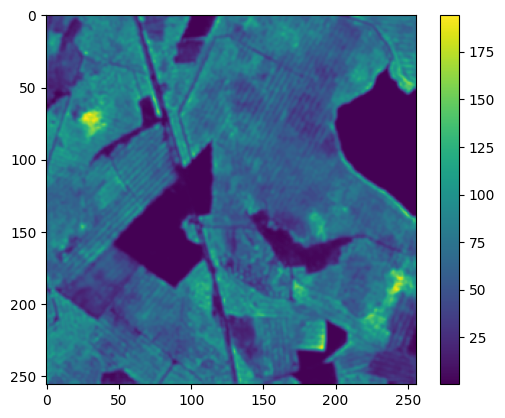

In [81]:
plt.imshow(test_pred)
plt.colorbar()
plt.show()

## 3D CNN

In [70]:
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score


# PyTorch libraries and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from plot3D import *

ModuleNotFoundError: No module named 'plot3D'

In [68]:
num_classes = 10
batch_size = 100

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(20, 32)
        self.conv_layer2 = self._conv_layer_set(100, 64)
        self.fc1 = nn.Linear(2**3*64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

#Definition of hyperparameters
n_iters = 4500
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

# Create CNN
model = CNNModel()
#model.cuda()
print(model)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv3d(20, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(100, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (batch): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.15, inplace=False)
)


In [98]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i,dp in enumerate(train_dataloader):
        images, labels = dp['image'],dp['label']
        images = images.unsqueeze(1).repeat(1,12,1,1,1)
        
        train = Variable(images.view(100, 20, 12, 256, 256))
        labels = Variable(labels)
        # Clear gradients
        optimizer.zero_grad()
        # Forward propagation
        outputs = model(train)
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_dataloader:
                
                test = Variable(images.view(100,20,12,256, 256))
                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

AttributeError: 'torch.Size' object has no attribute 'as_list'

torch.Size([100, 20, 256, 256])

In [39]:
i[1]['image']
i[1]['label']

tensor([[[[ 44.4100,  64.6900,  71.2400,  ..., 131.8800, 131.8800, 190.4500],
          [ 56.2100,  56.3600,  45.6300,  ..., 118.4900, 118.4900, 156.4200],
          [ 50.0600,  66.0900,  64.1600,  ...,  90.6600,  90.6600, 174.3000],
          ...,
          [ 67.1200,  54.3100,  73.2700,  ...,  96.8600,  96.8600, 126.8300],
          [ 78.7700,  58.8100,  51.8400,  ...,  83.8600,  83.8600,  26.1900],
          [ 62.4700,  80.0700,  47.5200,  ...,  44.5400,  44.5400,  49.4000]]],


        [[[ 22.5800,  26.0700,  20.1600,  ...,  21.8000,  21.4800,   9.2400],
          [ 25.0800,  25.0000,  14.2500,  ...,  33.2000,  28.3000,  56.6400],
          [ 25.0800,  25.0000,  14.2500,  ...,  33.2000,  28.3000,  56.6400],
          ...,
          [ 64.2300, 129.3900, 113.1900,  ...,  70.1100,  80.4900,   6.8400],
          [132.0200, 109.7000, 153.7100,  ...,   6.7600,   9.8300,   6.8300],
          [105.7700,  96.6900, 162.8000,  ...,   8.8000,   9.8100,   8.7400]]],


        [[[ 81.5100,  81.5

In [47]:
train_dataloader.batch_size

32

In [54]:
images.shape

torch.Size([100, 20, 256, 256])

In [59]:
images.unsqueeze(1).repeat(1,12,1,1,1).shape

torch.Size([100, 12, 20, 256, 256])

In [103]:
images.shape

torch.Size([100, 12, 20, 256, 256])

## Keras CNN

In [15]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
import tensorflow as tf
from keras.layers.core import Reshape

init_notebook_mode(connected=True)
%matplotlib inline

In [19]:
!nvidia-smi

Sat Dec 10 19:54:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 495.46       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:C3:00.0 Off |                  Off |
| 30%   30C    P8    18W / 230W |  10233MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    On   | 00000000:C4:00.0 Off |                  Off |
| 30%   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73.0M  100 73.0M    0     0  53.4M      0  0:00:01  0:00:01 --:--:-- 53.4M

Welcome to Miniconda3 py39_4.12.0

In order to continue the installation process, please review the license
agreement.
Please, press ENTER to continue
>>> ^C


In [21]:
!mkdir -p $CONDA_PREFIX/etc/conda/activate.d
!echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/' > $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh



In [22]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2022-12-10 19:56:01.533809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 19:56:01.637631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-10 19:56:01.637704: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-10 19:56:02.287848: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7:

In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14271976059493387219
xla_global_id: -1
]


2022-12-10 19:53:32.791594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 19:53:32.944742: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-10 19:53:32.944895: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-10 19:53:32.944974: W tensorflow/compiler/xla/

In [16]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

AttributeError: module 'tensorflow' has no attribute 'Session'

In [29]:
for i,dp in enumerate(train_dataloader):
    xtrain, y_train = dp['image'],dp['label']
    xtrain = xtrain.unsqueeze(1).repeat(1,12,1,1,1)
    break

for i,dp in enumerate(val_dataloader):
    xtest, y_test = dp['image'],dp['label']
    xtest = xtest.unsqueeze(1).repeat(1,12,1,1,1)
    break

In [30]:
xtest.shape

torch.Size([20, 12, 20, 256, 256])

In [31]:
xtrain = tf.convert_to_tensor(xtrain.reshape(100,12,256, 256, 20))
xtest = xtest.reshape(20,12,256, 256, 20)
x_test = tf.convert_to_tensor(xtest)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)                             
                             
## convert target variable into one-hot
#y_train = keras.utils.to_categorical(y_train, 10)
#y_test = keras.utils.to_categorical(y_test, 10)

In [35]:
## input layer
input_layer = Input((12,256, 256, 20))
#input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',padding='same')(input_layer)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',padding='same')(pooling_layer1)

## add max pooling to obtain the most imformatic features
#pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

#conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',padding='same')(pooling_layer1)
#conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu',padding='same')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=256*256)(dense_layer2)
output_layer = Reshape((1,256,256))(output_layer)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [37]:
%%time
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(learning_rate=0.1), metrics=['mean_squared_error'])
model.fit(x=xtrain, y=y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
3/3 [==============================] - 82s 24s/step - loss: 152308.0000 - mean_squared_error: 9365.7832 - val_loss: 133300.5156 - val_mean_squared_error: 7654.0532
Epoch 2/10
3/3 [==============================] - 74s 23s/step - loss: 152782.2812 - mean_squared_error: 9376.0713 - val_loss: 132533.8281 - val_mean_squared_error: 7653.0537
Epoch 3/10
3/3 [==============================] - 75s 23s/step - loss: 152345.2812 - mean_squared_error: 9374.2012 - val_loss: 132021.0781 - val_mean_squared_error: 7653.6006
Epoch 4/10


KeyboardInterrupt: 